In [545]:
import pandas as pd
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.preprocessing import (
    FunctionTransformer,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder   
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error
)
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest
import optuna
import datetime as dt
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [546]:
df = pd.read_excel('../data/Real estate valuation data set.xlsx', index_col='No')

In [547]:
df.columns

Index(['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [548]:
pattern = re.compile(r'X(\d+)\s|Y\s')
df.columns = list(map(lambda x: 
                            pattern.sub('', x)
                            .lower().replace(' ', '_'),
                    df.columns.values))



In [549]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_mrt_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [550]:
df.reset_index(inplace=True)
df.drop(columns='No', inplace=True)

In [551]:
df['transaction_date'] = df['transaction_date'].copy().astype('int')

In [552]:
df.nunique()

transaction_date                         2
house_age                              236
distance_to_the_nearest_mrt_station    259
number_of_convenience_stores            11
latitude                               234
longitude                              232
house_price_of_unit_area               270
dtype: int64

In [553]:
metadata = {
    'tgt': 'house_price_of_unit_area',
    'num_fts': df.select_dtypes(include='number').columns.tolist(),
    'cat_fts': df.select_dtypes(include='category').columns.tolist(),   
    'n_cols': df.shape[1]
}
metadata

{'tgt': 'house_price_of_unit_area',
 'num_fts': ['transaction_date',
  'house_age',
  'distance_to_the_nearest_mrt_station',
  'number_of_convenience_stores',
  'latitude',
  'longitude',
  'house_price_of_unit_area'],
 'cat_fts': [],
 'n_cols': 7}

In [554]:
def generate_fig(n_df_cols, fig_cols=3):
    fig_rows = (len(n_df_cols) // fig_cols) + 1 if len(n_df_cols) % fig_cols != 0 else len(n_df_cols) // fig_cols
    return fig_rows, fig_cols

In [555]:
fig_rows, fig_cols = generate_fig(metadata['num_fts'])

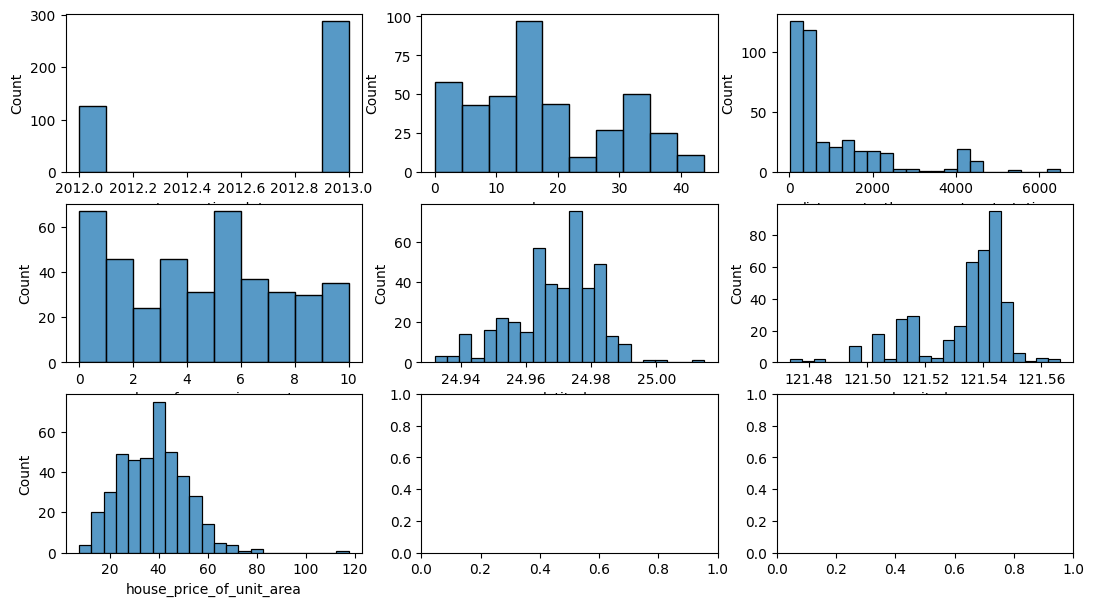

In [556]:
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(13, 7))

for i, col in enumerate(metadata['num_fts']):
    subp_col = i % fig_cols 
    subp_row = i // fig_cols 
    sns.histplot(df[col], ax=axes[subp_row, subp_col])



In [557]:
tsne = TSNE(n_components=3)

df_tsne = pd.DataFrame(
    data=tsne.fit_transform(df[metadata['num_fts']]),
    columns=tsne.get_feature_names_out()
)

In [558]:
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    opacity=0.5,
)
fig.show()

In [559]:
scaler = RobustScaler()
isf = IsolationForest(contamination=0.1, random_state=42)
outliers = isf.fit_predict(scaler.fit_transform(df.drop(columns=metadata['tgt'])))
outliers

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [560]:
df_tsne['outliers'] = outliers.astype(str)
fig = px.scatter_3d(
    data_frame=df_tsne,
    x=df_tsne.columns[0],
    y=df_tsne.columns[1],
    z=df_tsne.columns[2],
    color='outliers',
    color_discrete_map={
        '-1': 'red',
        '1': 'grey'
    }
)
fig.show()

In [561]:
mask = outliers == 1
df = df.loc[mask, :].copy()

In [562]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:,:-1], df.loc[:,metadata['tgt']], test_size=0.2, random_state=42, stratify=df['transaction_date'])    

In [563]:
def log_transformer():
    return FunctionTransformer(
        np.log1p,
        feature_names_out='one-to-one'
    )

num_pl = Pipeline(steps=[
    ('scaling',RobustScaler())
])

cat_pl = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pl, [col for col in Xtrain.columns if col != 'transaction_date' or col != 'distance_to_the_nearest_mrt_station']),
    ('cat', cat_pl, ['transaction_date']),
    ('log', Pipeline(steps=[
            ('log', log_transformer()),
            ('scaling', RobustScaler())
        ]), ['distance_to_the_nearest_mrt_station'])
])

preprocessor.fit(Xtrain)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['transaction_date', 'house_age',
                                  'distance_to_the_nearest_mrt_station',
                                  'number_of_convenience_stores', 'latitude',
                                  'longitude']),
                                ('cat',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['transaction_date']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('scaling', RobustScaler())]),
                                 ['distance_to_the_nearest_mrt_station'])])

In [564]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', XGBRegressor(enable_categorical=True, random_state=42, n_jobs=-1, objective='reg:squarederror', eval_metric='rmse', n_estimators=700, max_depth=8, learning_rate=0.001, reg_alpha=0.05, reg_lambda=0.05))
])

In [565]:
full_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['transaction_date',
                                                   'house_age',
                                                   'distance_to_the_nearest_mrt_station',
                                                   'number_of_convenience_stores',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['transaction_date']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   Fu...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.001,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=700, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [566]:
y_train_pred = full_pipeline.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.7147486517951076


In [567]:
y_test_pred = full_pipeline.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.559940497268576


In [568]:
lin_pl = Pipeline(steps=[
    ('scaling', RobustScaler()),
    ('model', LinearRegression())
])
lin_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('scaling', RobustScaler()), ('model', LinearRegression())])

In [569]:
y_train_pred = lin_pl.predict(Xtrain)
print(r2_score(ytrain, y_train_pred))

0.5401967286725331


In [570]:
y_test_pred = lin_pl.predict(Xtest)
print(r2_score(ytest, y_test_pred))

0.6422034118208824


In [571]:
scores = cross_val_score(
    cv=KFold(shuffle=True, random_state=42),
    estimator=lin_pl,
    scoring='neg_root_mean_squared_error',
    X=Xtrain,
    y=ytrain
)

(2.2190988793642323, -9.08139508202047)

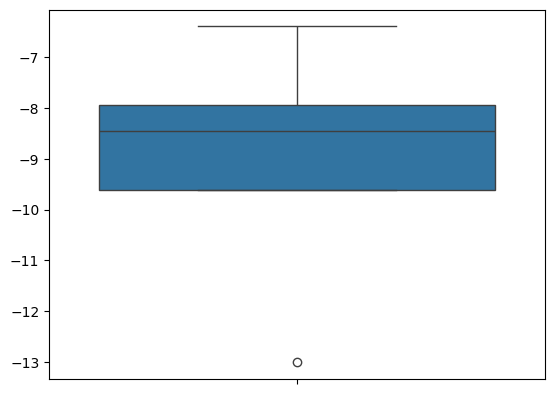

In [572]:
sns.boxplot(scores)
np.std(scores), np.mean(scores)

In [573]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
]

In [574]:
from sklearn.metrics import make_scorer


lin_models = {
    model.__class__.__name__: cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ]),
        scoring=make_scorer(r2_score),
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    for model in models
}

In [575]:
df = pd.DataFrame(
data=lin_models
)

In [576]:
df

,LinearRegression,Lasso,Ridge
0,0.895670,0.793026,0.894896
1,0.761610,0.644938,0.751430
2,0.249846,0.277283,0.259480
3,0.498223,0.342537,0.515273
4,0.535642,0.473073,0.538189
5,0.587721,0.687873,0.590753
6,0.773004,0.772100,0.762825
7,0.521634,0.471776,0.509512
8,0.562143,0.510322,0.562163
9,0.604210,0.553482,0.605140


<Axes: >

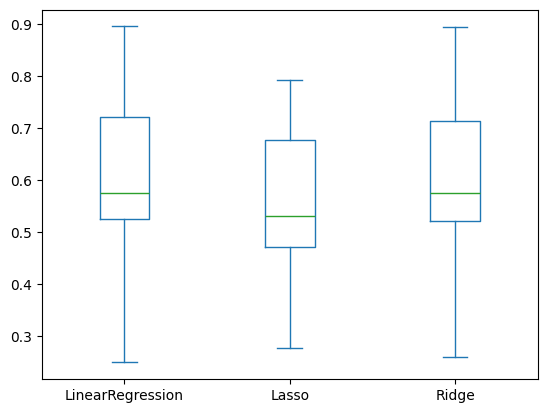

In [577]:
df.plot(kind='box')

In [578]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.1, 1.0),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
        'random_state': 42,
        'max_iter': trial.suggest_int('max_iter', 1000, 10000)
    }

    model = Ridge(**params)
    scores = cross_val_score(
        cv=KFold(shuffle=True, random_state=42, n_splits=10),
        estimator=Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]),
        scoring=make_scorer(r2_score),
        X=Xtrain,
        y=ytrain,
        n_jobs=-1
    )
    return np.mean(scores)

study = optuna.create_study(direction='maximize', study_name='Ridge',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)


[I 2024-05-29 10:22:29,912] A new study created in memory with name: Ridge
[I 2024-05-29 10:22:29,964] Trial 0 finished with value: 0.5986500641393733 and parameters: {'alpha': 0.4370861069626263, 'solver': 'auto', 'tol': 0.0006051038616257768, 'max_iter': 7373}. Best is trial 0 with value: 0.5986500641393733.
[I 2024-05-29 10:22:30,008] Trial 1 finished with value: 0.5984422338783608 and parameters: {'alpha': 0.1185260448662222, 'solver': 'auto', 'tol': 0.00043762556845569465, 'max_iter': 3621}. Best is trial 0 with value: 0.5986500641393733.
[I 2024-05-29 10:22:30,051] Trial 2 finished with value: 0.5988110523478314 and parameters: {'alpha': 0.6506676052501416, 'solver': 'sparse_cg', 'tol': 0.0005964904231734221, 'max_iter': 1418}. Best is trial 2 with value: 0.5988110523478314.
[I 2024-05-29 10:22:30,094] Trial 3 finished with value: 0.5988701184863624 and parameters: {'alpha': 0.6467903667112945, 'solver': 'lsqr', 'tol': 0.0006873906962470354, 'max_iter': 4961}. Best is trial 3 wit

In [579]:
ridge_best_params = study.best_params

In [580]:
optmized_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(**ridge_best_params))
])
optmized_ridge.fit(Xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['transaction_date',
                                                   'house_age',
                                                   'distance_to_the_nearest_mrt_station',
                                                   'number_of_convenience_stores',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['transaction_date']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaling',
                                                                   RobustScaler())]),
                                                  ['distance_to_the_nearest_mrt_station'])])),
                ('model',
                 Ridge(alpha=0.9771436405045867, max_iter=7482, solver='lsqr',
                       tol=0.0006652798609581047))])

In [581]:
optmized_ridge.score(Xtrain, ytrain)

0.5981125591157037

In [582]:
print(r2_score(ytrain, optmized_ridge.predict(Xtrain)))

0.5981125591157037


In [583]:
print(r2_score(ytest, optmized_ridge.predict(Xtest)))

0.7246682159843989


In [584]:
preprocessor.fit_transform(Xtrain)

array([[ 0.        ,  0.29347826,  0.39922159, ...,  0.77448071,
         1.        ,  0.37288806],
       [ 0.        , -0.5923913 , -0.04191477, ..., -0.1760633 ,
         1.        , -0.05160233],
       [ 0.        , -0.82608696, -0.24243913, ...,  0.49653808,
         1.        , -0.35923473],
       ...,
       [-1.        , -0.28804348, -0.26237782, ...,  0.57863501,
         0.        , -0.39749784],
       [ 0.        ,  1.39673913, -0.48853005, ...,  0.27101879,
         1.        , -1.04912586],
       [-1.        , -0.11956522,  0.04489522, ..., -0.21661721,
         0.        ,  0.05178926]])

In [585]:
trsf_df = pd.DataFrame(
    data=preprocessor.transform(Xtrain),
    columns=preprocessor.get_feature_names_out()
)
trsf_df

,num__transaction_date,num__house_age,num__distance_to_the_nearest_mrt_station,num__number_of_convenience_stores,num__latitude,num__longitude,cat__transaction_date,log__distance_to_the_nearest_mrt_station
0,0.0,0.293478,0.399222,-0.6,0.651049,0.774481,1.0,0.372888
1,0.0,-0.592391,-0.041915,0.4,0.621678,-0.176063,1.0,-0.051602
2,0.0,-0.826087,-0.242439,0.2,0.407692,0.496538,1.0,-0.359235
3,0.0,0.081522,5.222078,-1.0,-2.102098,-3.536103,1.0,1.730830
4,0.0,-0.385870,-0.513843,0.0,-0.340559,0.109792,1.0,-1.171046
...,...,...,...,...,...,...,...,...
292,0.0,1.103261,0.259073,-0.4,0.281119,-0.238378,1.0,0.260877
293,0.0,0.967391,-0.403852,0.8,0.374825,0.302671,1.0,-0.739864
294,-1.0,-0.288043,-0.262378,0.4,0.256643,0.578635,0.0,-0.397498
295,0.0,1.396739,-0.488530,0.6,-0.283217,0.271019,1.0,-1.049126


<Axes: >

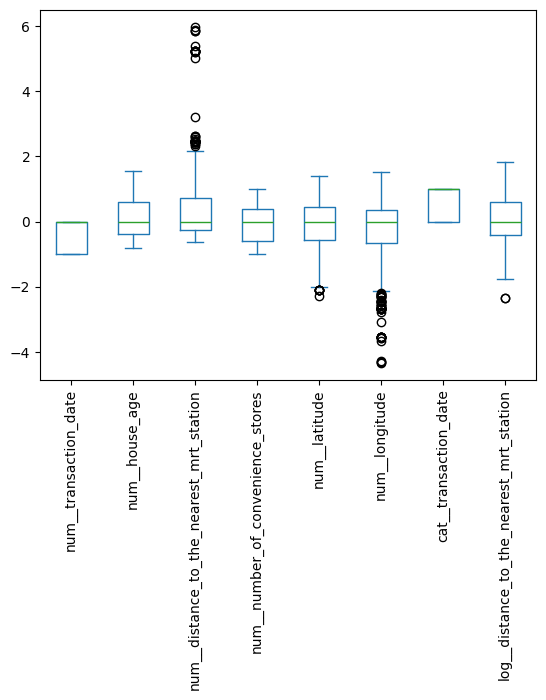

In [586]:
trsf_df.plot(kind='box', rot = 90)